In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import utilities as u
import single_session_plots as ssp
import numpy as np
import scipy as sp
import sklearn as sk
from matplotlib import pyplot as plt
from LatentVarFuncs import *
import pickle
import scipy as sp
%matplotlib inline

%load_ext autoreload
%autoreload 2

C:\Users\mplitt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load data
# import behavioral sessions
mouse = '4139190.1'
df = u.load_session_db()

df = df[df['RewardCount']>10]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime'])

df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse = df_mouse.sort_values(['DateTime'])

# pick candidate session
sess = df_mouse.iloc[4]

# get behavior and imaging data
behav = u.behavior_dataframe(sess['data file'],sess['scanmat'],concat=False)
d = u.by_trial_info(behav)


info = u.loadmat_sbx(sess['scanmat'])['info']
ca_dat = u.load_ca_mat(sess['scanfile'])

C = ca_dat['C_keep'][info['frame'][0]:info['frame'][-1]+1]

frame_diff = behav.shape[0]-C.shape[0]
if frame_diff>0:
    behav = behav.iloc[:-frame_diff]
    
    
C_z = sp.stats.zscore(C,axis=0)
del(C)
del(df)

G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:479: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat
#subsystem#not made into numpy array


In [3]:
# load ML parameters
alpha = np.linspace(.5,1,5)
beta = np.linspace(.5,1,5)
for i,a in enumerate(alpha.tolist()):
    for j,b in enumerate(beta.tolist()):
        # save results
        #print(i,j)
        fname = "G:\\My Drive\\MCN\\project\\ParamSweep\\LL_alpha%f_beta%f.p" % (a,b)
        #LL = pickle.load(open(fname,'rb'))
       
        with open(fname,'rb') as f:
            #print(f)
            LL = pickle.load(f)
        
        
        
        for k,cell in enumerate(LL.keys()):
            if i==0 and j==0 and k == 0:
                ML_params = np.zeros([5,5,len(LL[cell]),len(LL.keys())])
            else:
                ML_params[i,j,:,k] = LL[cell]
                
# get MLE parameters
alpha_hat = np.zeros([ML_params.shape[2],ML_params.shape[3]])
beta_hat = np.zeros([ML_params.shape[2],ML_params.shape[3]])
for trial in range(ML_params.shape[2]):
    for cell in range(ML_params.shape[3]):
        a_ind,b_ind = np.unravel_index(np.argmax(ML_params[:,:,trial,cell]),[5,5])
        alpha_hat[trial,cell] = alpha[a_ind]
        beta_hat[trial,cell] = beta[b_ind]

In [4]:
# get mask for which cells are used and data for decoding

#  set up encoding models
dmat = pos_morph_design_matrix(behav['pos']._values,behav['morph']._values)
train_inds = ((behav['morph']==1) | (behav['morph']==0)) & (behav['pos']>0)
dmat_extreme = dmat[train_inds,:]
C_extreme = C_z[train_inds,:]

glm_base = sk.linear_model.LinearRegression()

# for cells in session
glm_base.fit(dmat_extreme,C_extreme)
mu_extreme_hat = glm_base.predict(dmat_extreme)


# restrict analysis to cells for which the encoding model was reasonable
r2 = []
for cell in range(C_z.shape[1]):
    glm_tmp = sk.linear_model.LinearRegression()
    glm_tmp.fit(dmat_extreme,C_extreme[:,cell])
    mu_extreme_hat = glm_tmp.predict(dmat_extreme)
    r2.append(glm_tmp.score(dmat_extreme,C_extreme[:,cell]))
r2 = np.array(r2)
r2mask = r2>.05 # arbitrary based on histogram of r2 values
glm_final = sk.linear_model.LinearRegression()
glm_final.fit(dmat_extreme,C_extreme[:,r2mask])

# find position transition probabilities
morph0inds = behav['morph']==0
XX_I0, xbins = transition_prob_matrix(behav['pos']._values[morph0inds],binsize=5)

morph1inds = behav['morph']==1
XX_I1, xbins = transition_prob_matrix(behav['pos']._values[morph1inds],binsize=5)
xbins = np.array(xbins)

pos_binned = np.digitize(behav['pos']._values,xbins,right=True)



# get trial by trial info
tstarts,tstops = np.where(behav['tstart']==1)[0],np.where(behav['teleport']==1)[0]
trial_pos, trial_C_z  = [], []
for (start,stop) in zip(tstarts,tstops):
    trial_pos.append(behav['pos']._values[start:stop])
    trial_C_z.append(C_z[start:stop,r2mask]) # restrict to well fit cells
d = u.by_trial_info(behav)

# get data for estimating all likelihoods
mu_i0 = glm_final.predict(pos_morph_design_matrix(xbins,np.zeros([xbins.shape[0],])))
mu_i1 = glm_final.predict(pos_morph_design_matrix(xbins,np.ones([xbins.shape[0],])))



C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:479: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


In [49]:
# single cell decoding
decode_dict= decoding_model(trial_C_z,XX_I0,XX_I1,mu_i0,mu_i1,alpha_hat,beta_hat,d['morphs'])


processing trial 0


C:\Users\mplitt\LatentFlailing\LatentVarFuncs.py:236: RuntimeWarning: divide by zero encountered in log
  log_tmpnum0 = log_L0 + np.squeeze(np.log(XXZZ0))
C:\Users\mplitt\LatentFlailing\LatentVarFuncs.py:243: RuntimeWarning: divide by zero encountered in log
  log_tmpnum1 = log_L1 + np.squeeze(np.log(XXZZ1))


processing trial 5
processing trial 10
processing trial 15
processing trial 20
processing trial 25
processing trial 30
processing trial 35
processing trial 40
processing trial 45
processing trial 50
processing trial 55
processing trial 60
processing trial 65
processing trial 70
processing trial 75
processing trial 80
processing trial 85
processing trial 90
processing trial 95
processing trial 100
processing trial 105
processing trial 110


In [6]:
#
print(decode_dict.keys())

dict_keys(['i0x_y', 'i1x_y', 'i0', 'i1'])


C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


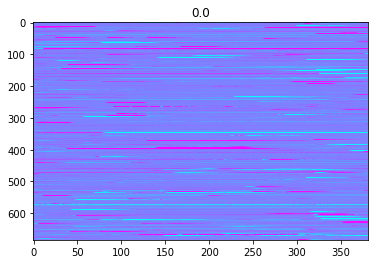

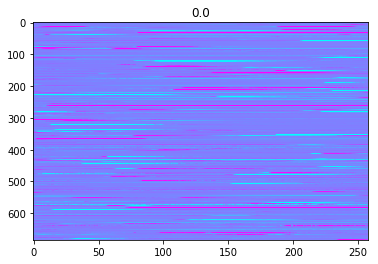

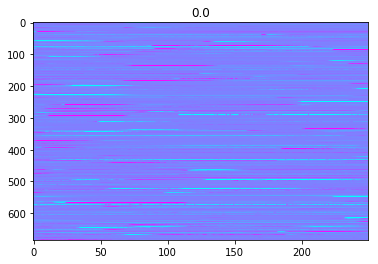

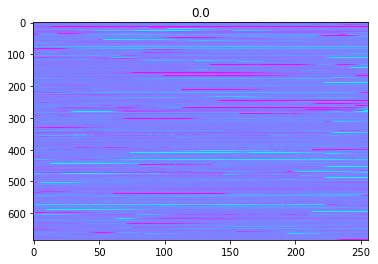

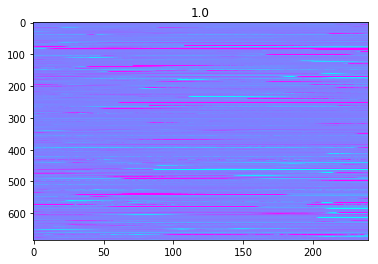

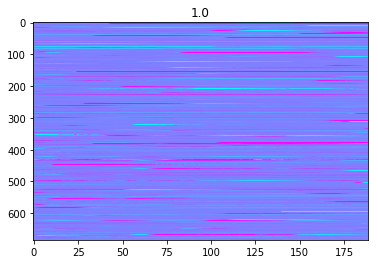

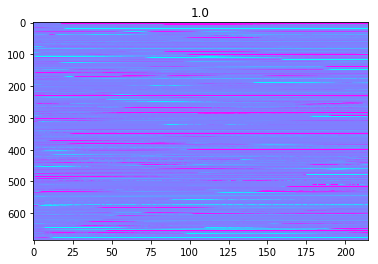

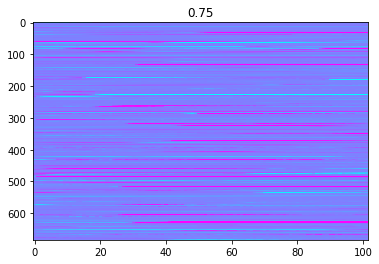

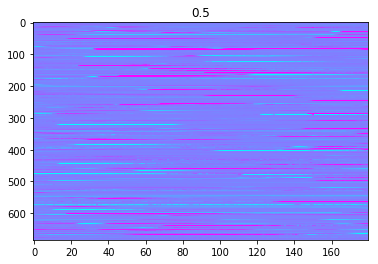

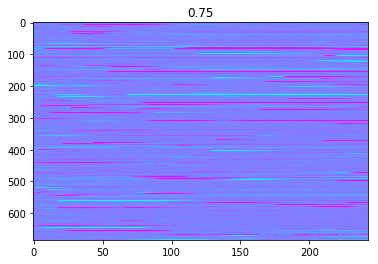

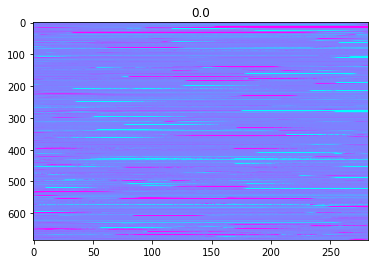

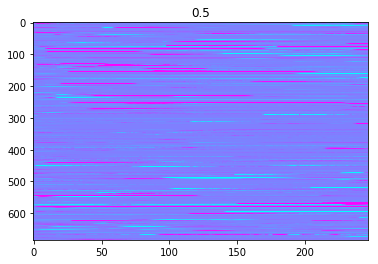

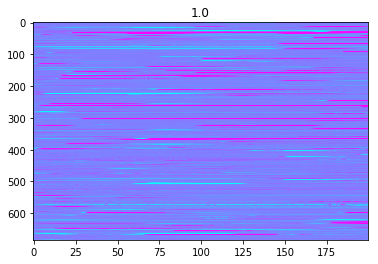

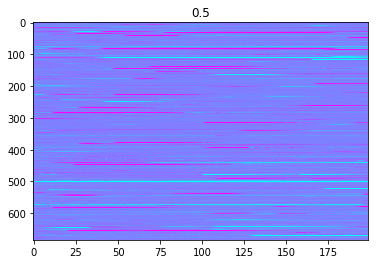

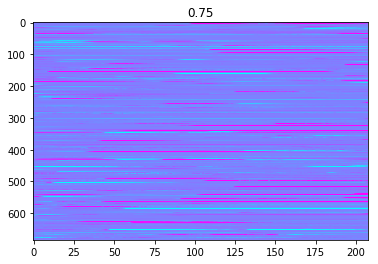

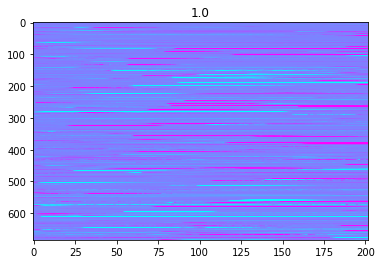

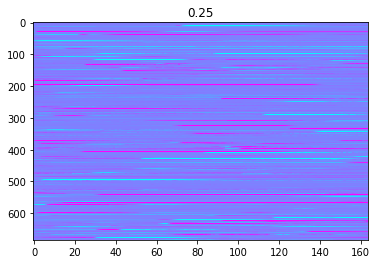

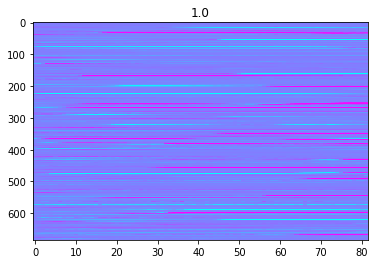

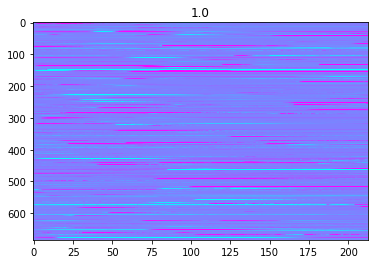

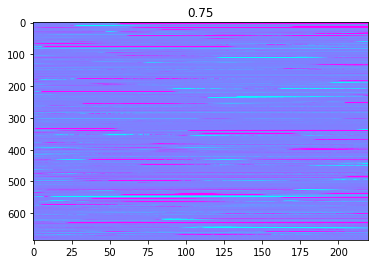

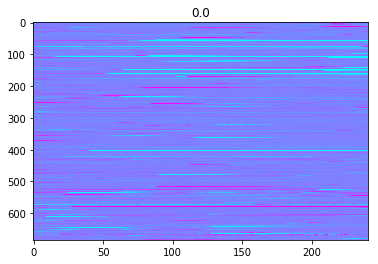

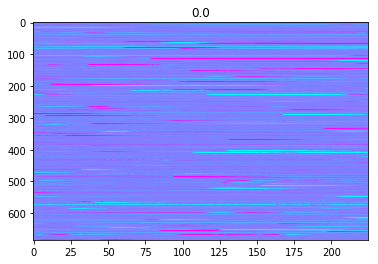

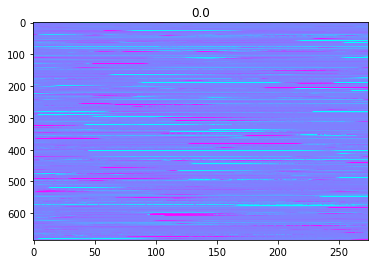

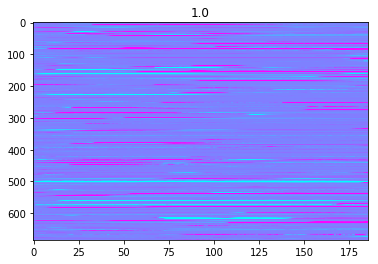

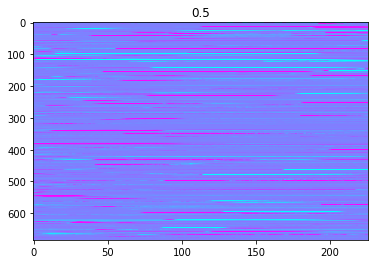

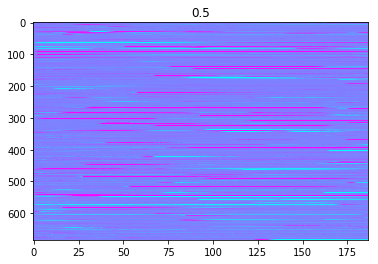

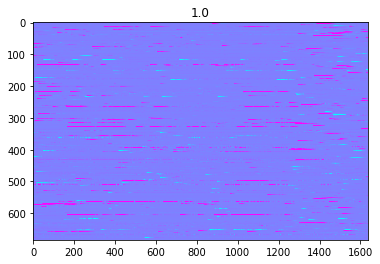

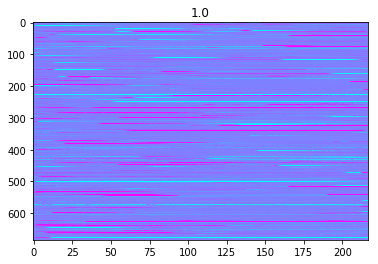

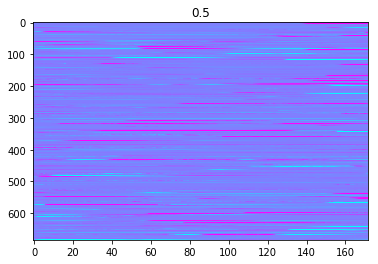

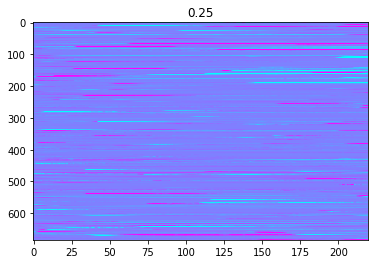

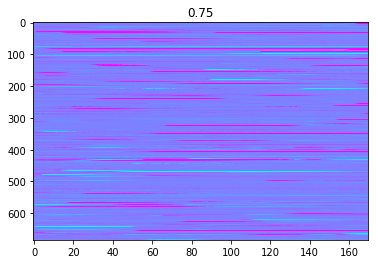

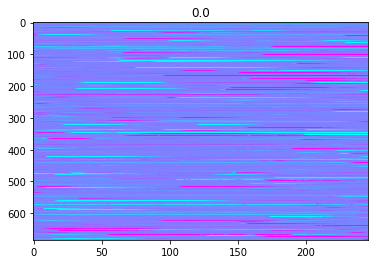

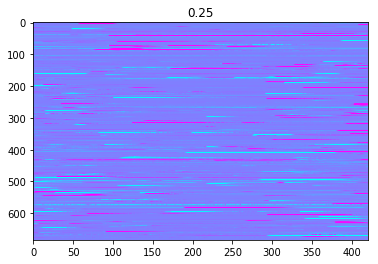

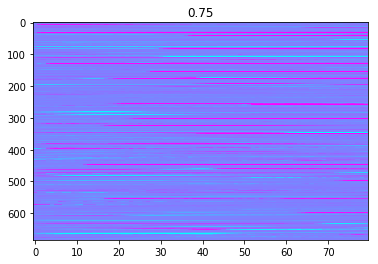

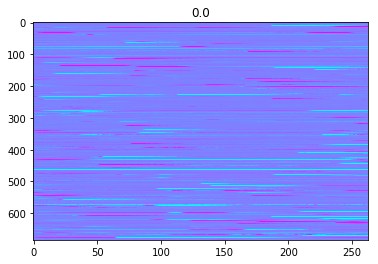

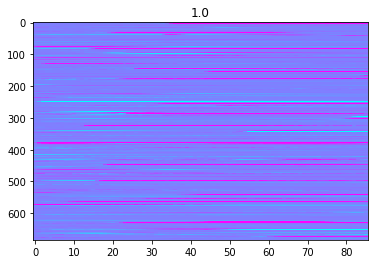

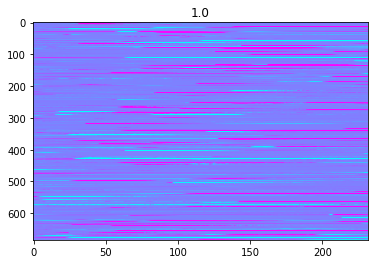

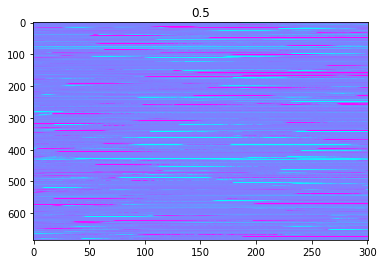

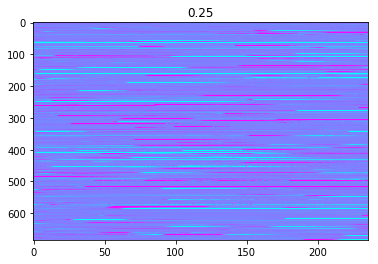

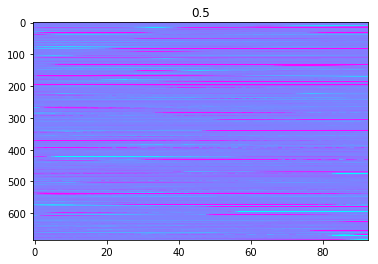

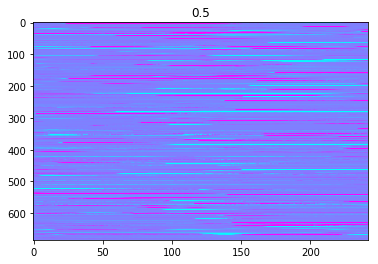

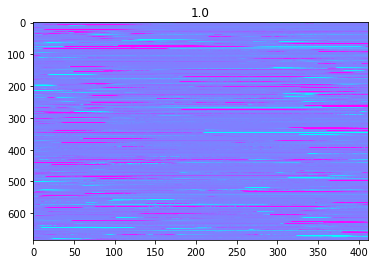

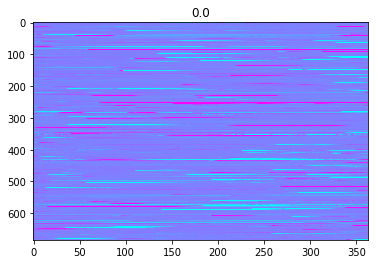

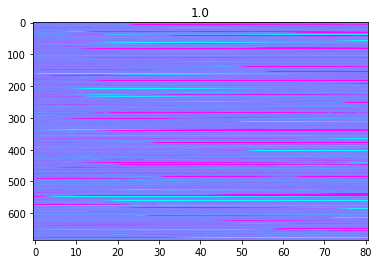

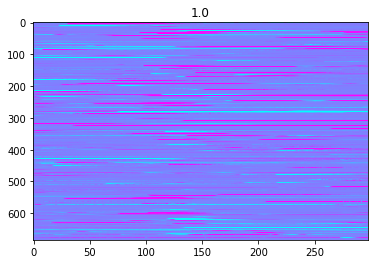

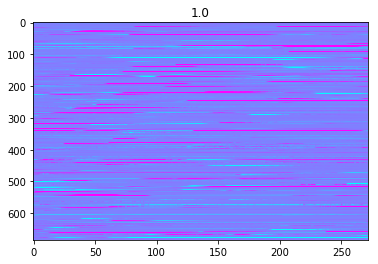

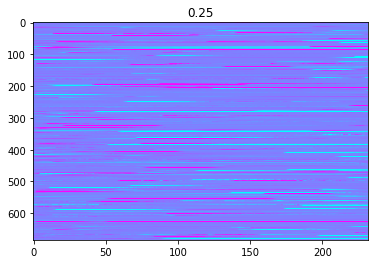

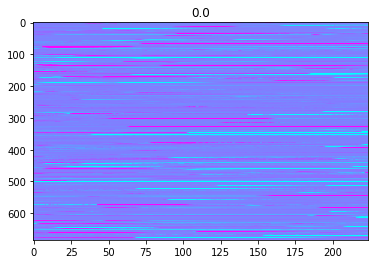

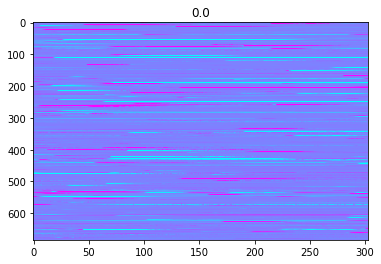

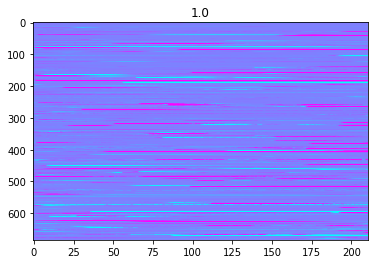

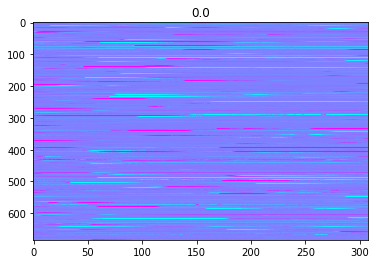

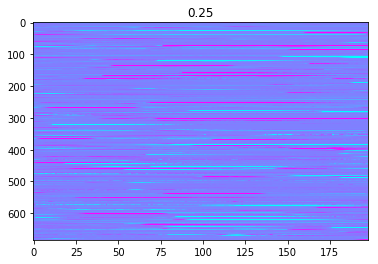

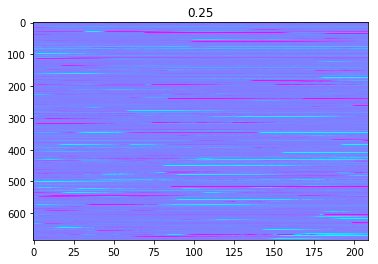

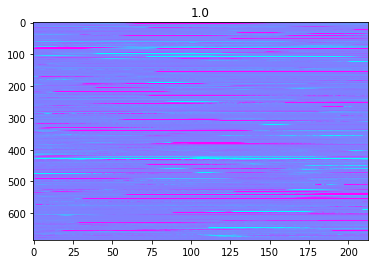

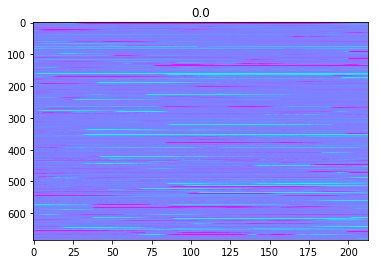

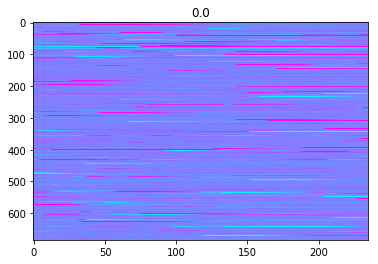

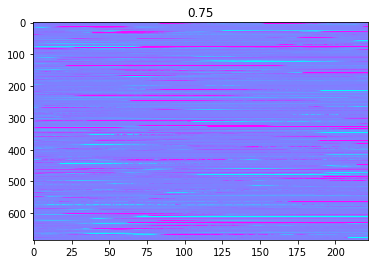

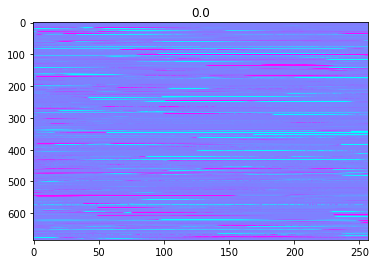

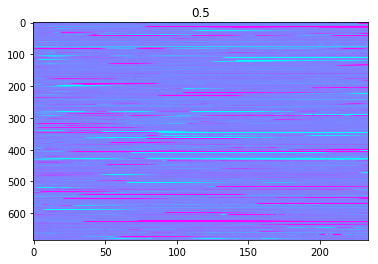

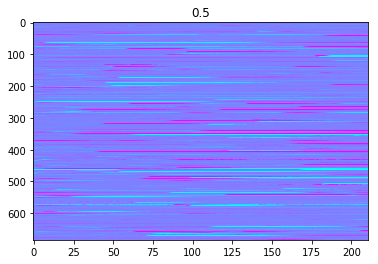

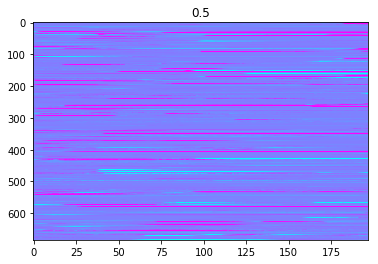

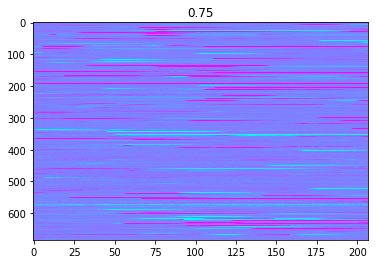

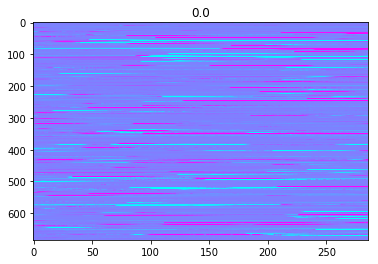

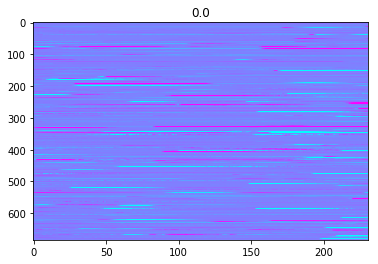

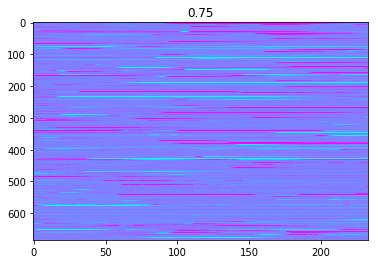

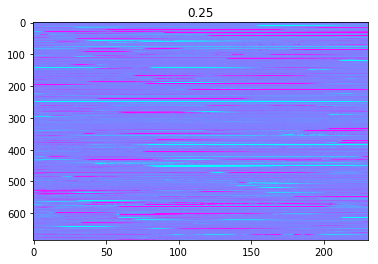

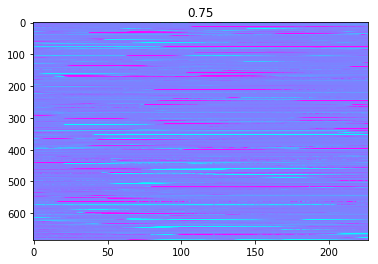

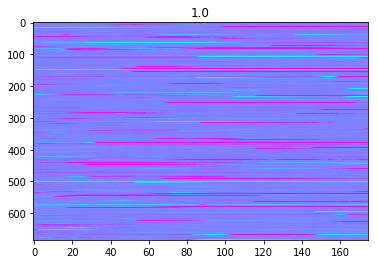

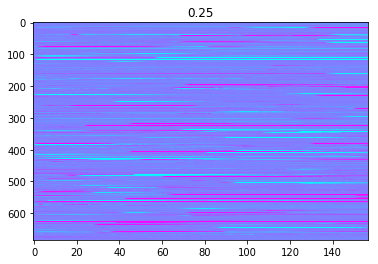

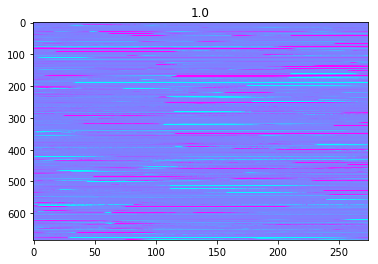

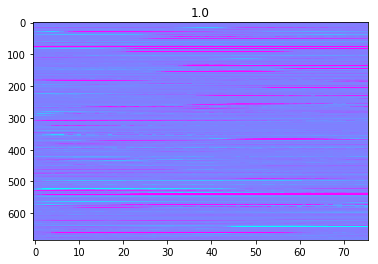

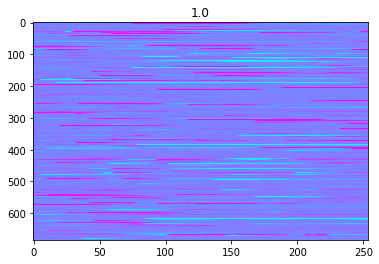

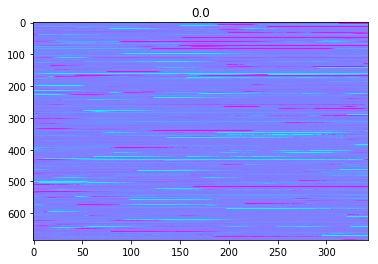

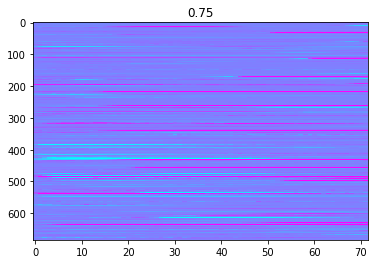

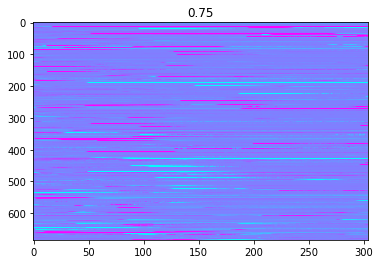

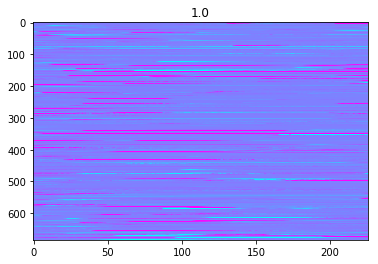

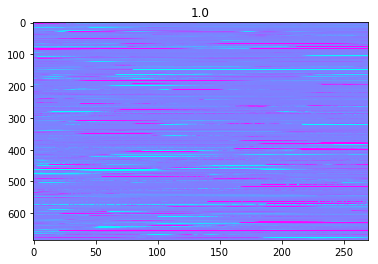

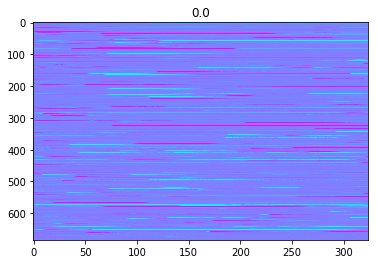

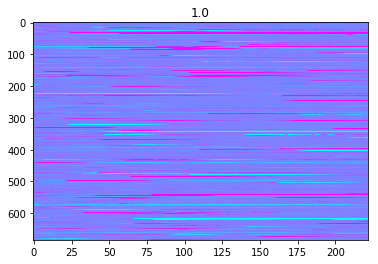

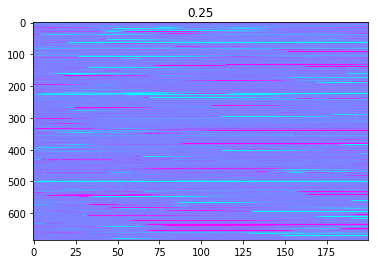

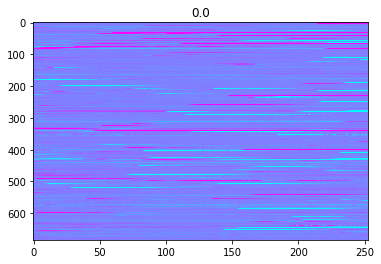

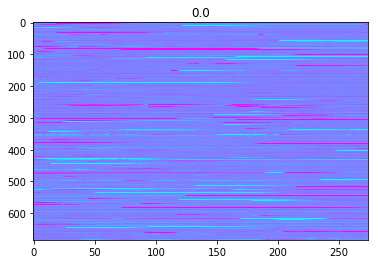

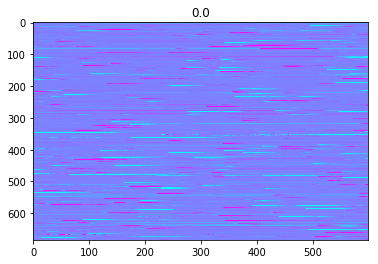

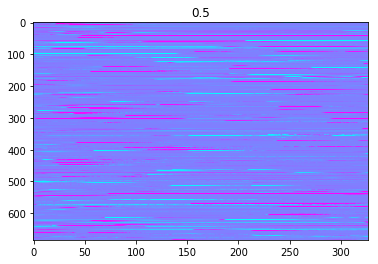

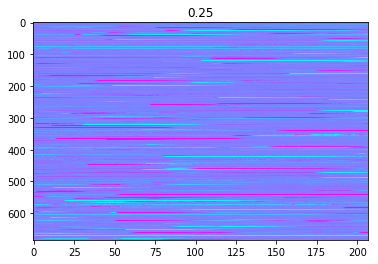

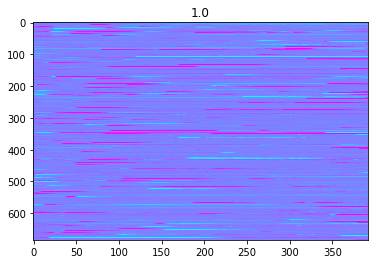

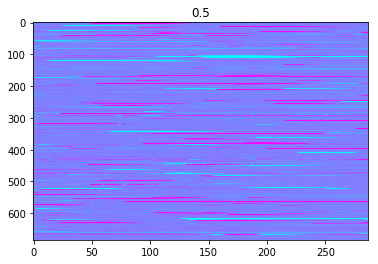

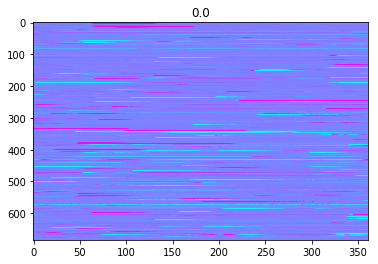

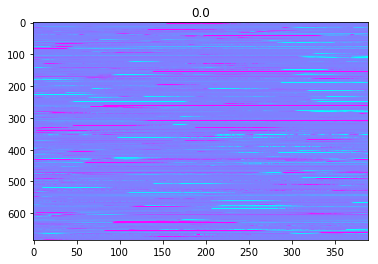

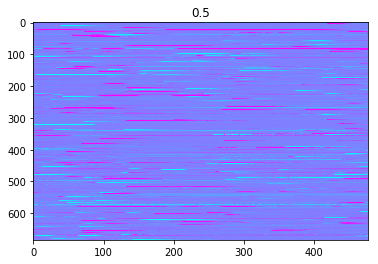

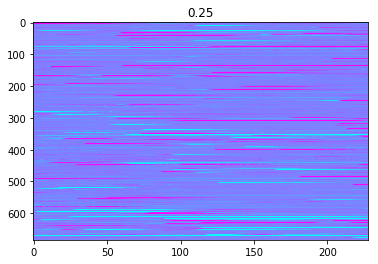

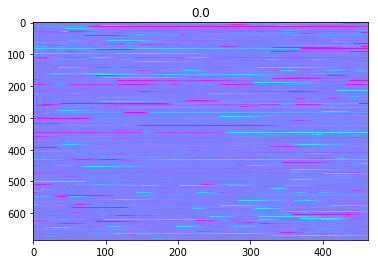

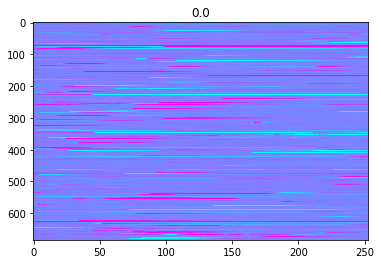

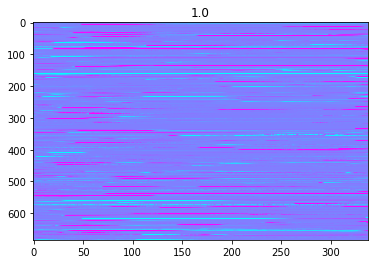

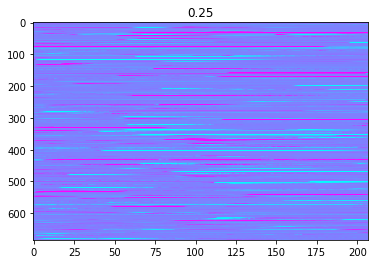

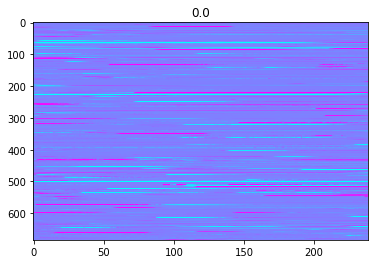

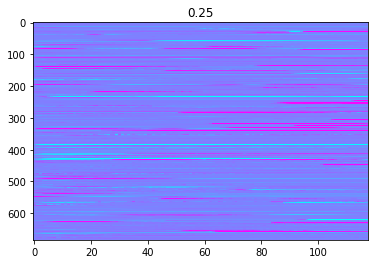

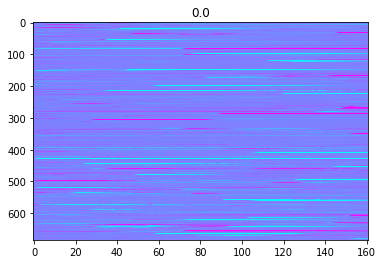

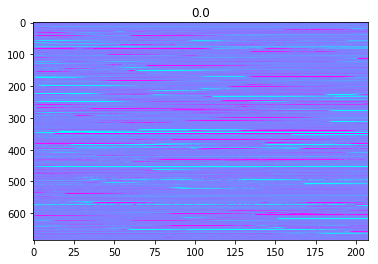

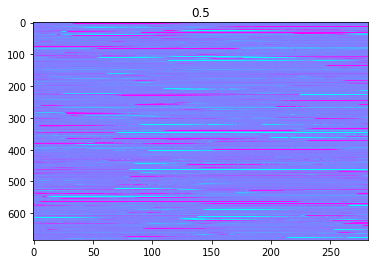

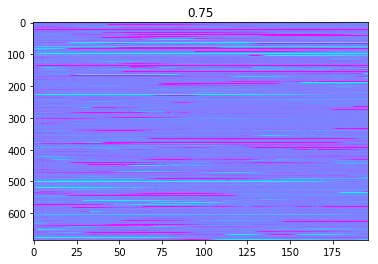

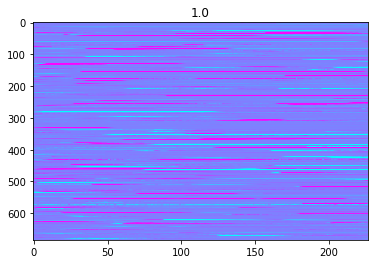

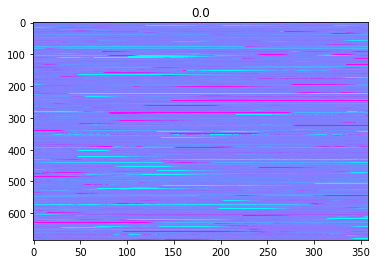

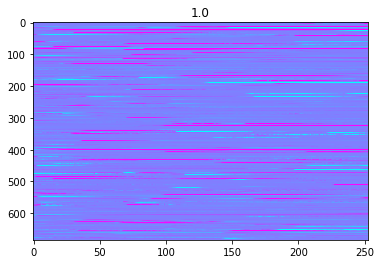

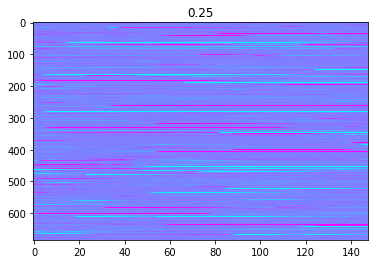

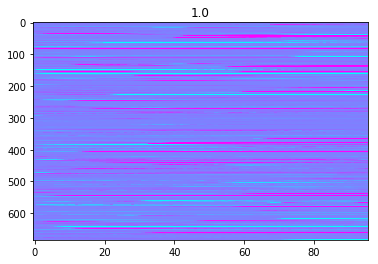

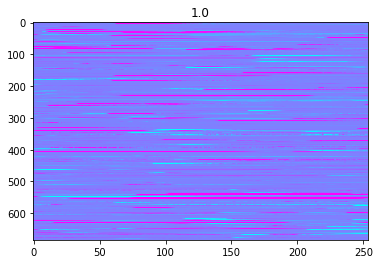

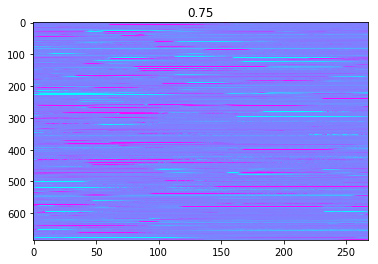

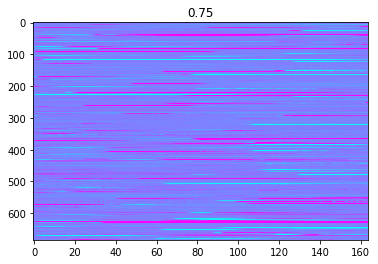

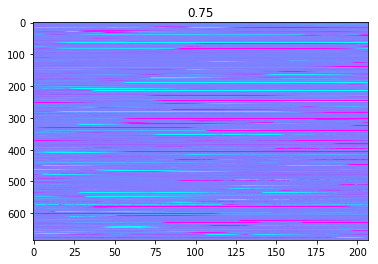

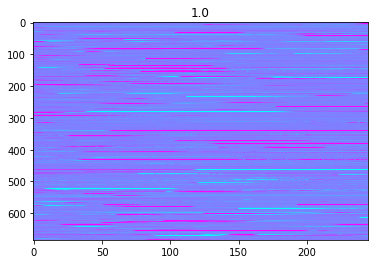

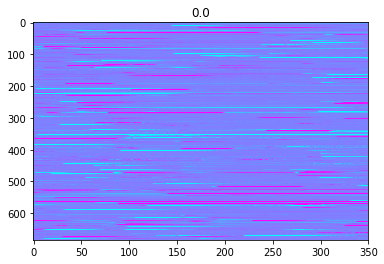

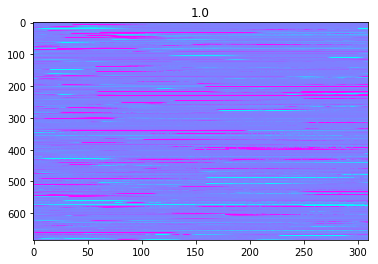

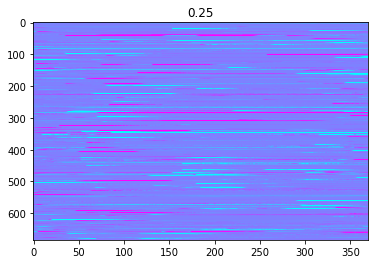

In [33]:
for i, (tmppost, tmppos,m) in enumerate(zip(decode_dict['i1'],trial_pos,d['morphs'])):
    #if m>0 and m<1:
    f,ax = plt.subplots()
    ax.imshow(tmppost.T,aspect='auto',cmap='cool',vmin=0,vmax=1)
    ax.set_title(m)
    f.savefig("G:\\My Drive\\MCN\\project\\SingleCellContextDecodingPlots\\trial%d_morph%f.pdf" % (i,m))

In [18]:
pop_post_lr = []
pop_P0x, pop_P1x = [],[]
for tmp0, tmp1 in zip(decode_dict['i0x_y'],decode_dict['i1x_y']):
    
    P1 = tmp1.sum(axis=1)
    P0 = tmp0.sum(axis=1)
    
    P0_x = np.log(tmp0).sum(axis=2)
    P0_x -= P0_x.max() 
    P0_x = np.exp(P0_x)
    
    P1_x = np.log(tmp1).sum(axis=2)
    P1_x -= P1_x.max() 
    P1_x = np.exp(P1_x)

    #denom = np.maximum(P0_x.sum(axis=1) + P1_x.sum(axis=1),1e-10)
    #print(np.where(denom==0)[0])
    #print(denom.shape)
    #denom = np.matlib.repmat(denom[np.newaxis].T,1,P1_x.shape[1])
    #print(denom.shape,P0_x.shape)
    
    pop_P0x.append(P0_x)
    pop_P1x.append(P1_x)
    
    #pop_post_lr.append(np.divide(P0_x.sum(axis=1)+1e-10,P1_x.sum(axis=1)+1e-10))
    pop_post_lr.append(np.divide(np.log(P0).sum(axis=1),np.log(P1).sum(axis=1)))

C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


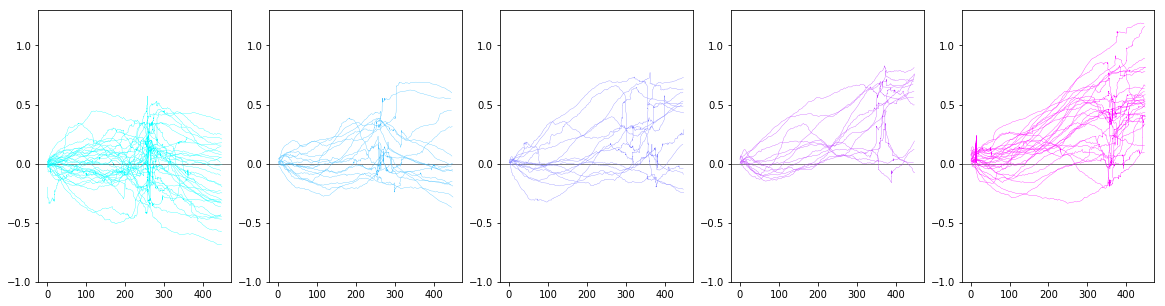

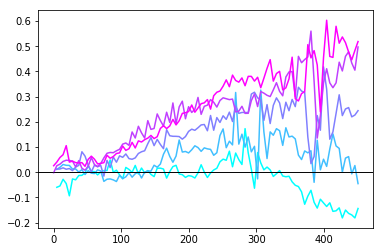

In [32]:
f,ax = plt.subplots(1,5,figsize=[20,5])
nbins = 100
xbins = np.linspace(0,460,nbins)
mcount = {0:np.zeros([nbins,]), .25:np.zeros([nbins,]), .5:np.zeros([nbins,]), .75:np.zeros([nbins,]), 1.:np.zeros([nbins,])}
avgTrace = {0:np.zeros([nbins,]), .25:np.zeros([nbins,]), .5:np.zeros([nbins,]), .75:np.zeros([nbins,]), 1.:np.zeros([nbins,])}
#for key in avgTrace.keys():
#    avgTrace[key][:]=np.nan

for i,(lr,tmppos,m,r)  in enumerate(zip(pop_post_lr,trial_pos,d['morphs'],d['rewards'])): 
    if r>0:
        if m == 0:
            ax[0].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
            ax[0].set_ylim([-1,1.3])
            
        elif m == .25:
            ax[1].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
            ax[1].set_ylim([-1,1.3])
        elif m  == .5 :
            ax[2].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
            ax[2].set_ylim([-1,1.3])
        elif m == .75:
            ax[3].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
            ax[3].set_ylim([-1,1.3])
            
        elif m == 1.:
            ax[4].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
            ax[4].set_ylim([-1,1.3])
            
        if i == 0:
            for j in range(5):
                ax[j].axhline(0,xmin=0,xmax=460,color='black',linewidth=.5)
        #ax[0].set_xlim([250,310])
    #if r<1:
    #    ax[1].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
    #    ax[1].set_ylim([-1,1.3])
    #if m>0 and m<1:
    #    ax[2].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
    #    ax[2].set_ylim([-1,1.3])
    #if m==.5:
    #    ax[3].plot(tmppos[:],np.log(lr[:]),color=plt.cm.cool(m),linewidth=.3)
    #    ax[3].set_ylim([-1,1.3])
    
    
    posbins = np.digitize(tmppos,xbins,right=True)
    #bcounts = np.bincounts(pos,xbins)
    emptyTrace = np.zeros([nbins,])
 #   emptyTrace[:]=np.nan
    for z in range(nbins):
        avgTrace[m][z] += np.log(lr[posbins==z]).sum()
        mcount[m][z] += sum(posbins==z)
f.savefig("G:\\My Drive\\MCN\\project\\ContextDecodingPlots\\singletrials.pdf")
        
f,ax = plt.subplots()
for key in avgTrace.keys():
    avgTrace[key] = np.divide(avgTrace[key],mcount[key])
    #print(avgTrace[key])
    ax.plot(xbins,avgTrace[key],color=plt.cm.cool(np.float(key)))
    ax.axhline(0,xmin=0,xmax=460,color='black',linewidth=.5)

f.savefig("G:\\My Drive\\MCN\\project\\ContextDecodingPlots\\trialavg.pdf")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 215 but corresponding boolean dimension is 102

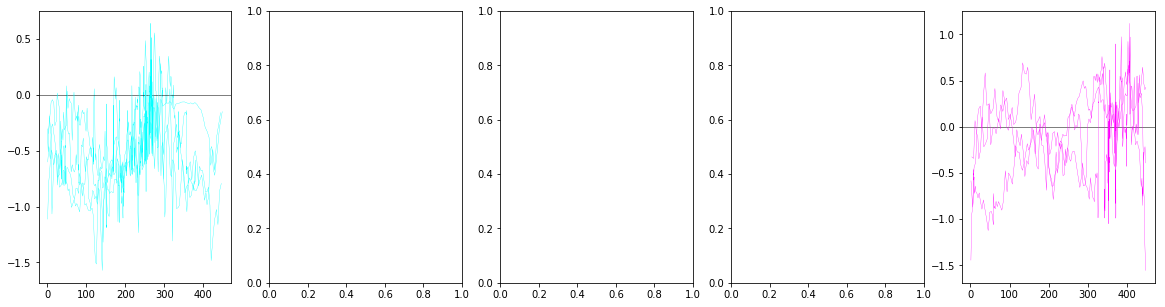

In [55]:
f,ax = plt.subplots(1,5,figsize=[20,5])
nbins = 100
xbins = np.linspace(0,460,nbins)
mcount = {0:np.zeros([nbins,]), .25:np.zeros([nbins,]), .5:np.zeros([nbins,]), .75:np.zeros([nbins,]), 1.:np.zeros([nbins,])}
avgTrace = {0:np.zeros([nbins,]), .25:np.zeros([nbins,]), .5:np.zeros([nbins,]), .75:np.zeros([nbins,]), 1.:np.zeros([nbins,])}
#for key in avgTrace.keys():
#    avgTrace[key][:]=np.nan

for i,(lr1,lr0,tmppos,m,r)  in enumerate(zip(decode_dict['pop i1'],decode_dict['pop i0'],trial_pos,d['morphs'],d['rewards'])): 
    lr = np.log(np.divide(lr1,lr0))
    if r>0:
        
        if m == 0:
            ax[0].plot(tmppos[:],lr,color=plt.cm.cool(m),linewidth=.3)
            #ax[0].set_ylim([-1,1.3])
            
        elif m == .25:
            ax[1].plot(tmppos[:],lr,color=plt.cm.cool(m),linewidth=.3)
            #ax[1].set_ylim([-1,1.3])
        elif m  == .5 :
            ax[2].plot(tmppos[:],lr,color=plt.cm.cool(m),linewidth=.3)
            #ax[2].set_ylim([-1,1.3])
        elif m == .75:
            ax[3].plot(tmppos[:],lr,color=plt.cm.cool(m),linewidth=.3)
            #ax[3].set_ylim([-1,1.3])
            
        elif m == 1.:
            ax[4].plot(tmppos[:],lr,color=plt.cm.cool(m),linewidth=.3)
            #ax[4].set_ylim([-1,1.3])
            
        if i == 0:
            for j in range(5):
                ax[j].axhline(0,xmin=0,xmax=460,color='black',linewidth=.5)
   
    
    
    posbins = np.digitize(tmppos,xbins,right=True)
    #bcounts = np.bincounts(pos,xbins)
    emptyTrace = np.zeros([nbins,])
 #   emptyTrace[:]=np.nan
    for z in range(nbins):
        avgTrace[m][z] += lr[posbins==z].sum()
        mcount[m][z] += sum(posbins==z)
#f.savefig("G:\\My Drive\\MCN\\project\\ContextDecodingPlots\\singletrials.pdf")
        
f,ax = plt.subplots()
for key in avgTrace.keys():
    avgTrace[key] = np.divide(avgTrace[key],mcount[key])
    #print(avgTrace[key])
    ax.plot(xbins,avgTrace[key],color=plt.cm.cool(np.float(key)))
    #ax.axhline(0,xmin=0,xmax=460,color='black',linewidth=.5)

#f.savefig("G:\\My Drive\\MCN\\project\\ContextDecodingPlots\\trialavg.pdf")

In [ ]:
# reliability - pro

(380, 93)
(257, 93)


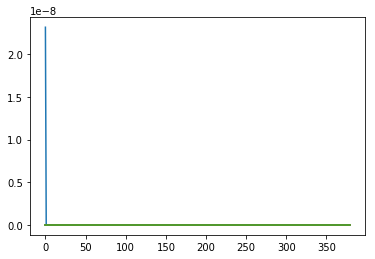

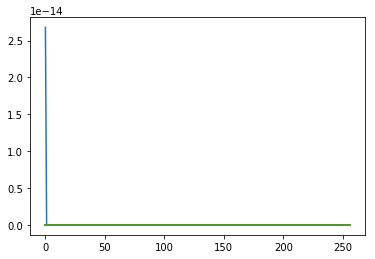

In [31]:
# population decoding of position
for t in range(2): #d['morphs'].shape[0]):
    #print(np.array(pop_P0x[t]).shape)
    px = np.hstack((np.array(pop_P0x[t]),np.array(pop_P1x[t])))
    f, ax = plt.subplots()
    print(pop_P0x[t][1:,:].shape)
    
    ax.plot(np.log(pop_P1x[t][1:,:]))
    #ax.imshow(pop_P0x[t][1:,:])


In [6]:
# population decoding of context

In [ ]:
# 